## NCEP3 Example

The Goddard Satellite-based Surface Turbulent Fluxes (GSSTF) Version 3 Dataset is a product of the NASA MEaSURES project. The dataset consists of 7,855 files in the HDF-EOS5 format. Each file contains one-day worth of data in the Equidistant Cylindrical projection on the global 0.25×0.25 degree grid cell. The dataset's temporal coverage is from July 1, 1987 to January 1, 2009. More information is available at https://disc.gsfc.nasa.gov/datasets/GSSTF_NCEP_V3/summary.

The 7,855 files have been aggregated to one domain hosted by HDF Kita at location: hdf5://shared/NASA/NCEP3/ncep3.h5.

This notebook illustrates how this data can be accessed using h5pyd.

In [1]:
import sys
!{sys.executable} -m pip install git+https://git@github.com/HDFGroup/h5pyd --upgrade

  Cloning https://****@github.com/HDFGroup/h5pyd to /tmp/pip-req-build-07qwqq55
  Running command git clone -q 'https://****@github.com/HDFGroup/h5pyd' /tmp/pip-req-build-07qwqq55


In [2]:
%matplotlib inline
import h5pyd as h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

In [3]:
f = h5py.File("hdf5://shared/NASA/NCEP3/ncep3.h5")

In [4]:
list(f["/HDFEOS/GRIDS/NCEP/Data Fields"])

['Psea_level', 'Qsat', 'SST', 'Tair_2m']

In [5]:
tair2m = f["/HDFEOS/GRIDS/NCEP/Data Fields/Tair_2m"]
tair2m

<HDF5 dataset "Tair_2m": shape (7855, 720, 1440), type "<f4">

In [6]:
tair2m.chunks

(1, 720, 1440)

In [7]:
# the layout property provides information on how the dataset data is stored.
layout = tair2m.id.layout
layout

{'class': 'H5D_CHUNKED_REF_INDIRECT',
 'dims': [1, 720, 1440],
 'chunk_table': 'd-8001f6c6-c88d278f-13d4-7747f1-af1ccc'}

In [8]:
# The chunktable is an anonymous dataset that contains
# information about where the chunks are located in the source files
chunktable_id = layout['chunk_table']
chunktable = f["datasets/" + chunktable_id]
chunktable

<HDF5 dataset ("anonymous"): shape (7855, 1, 1), type "|V20">

In [9]:
# each entry is offset, size, and s3 uri to the chunk
chunktable[0:5,:,:]

array([[[(4646149, 1501870, b's3://hdf5.sample/data/NASA/NCEP3/GSSTF_NCEP.3.1987.07.01.h5')]],

       [[(4648806, 1500817, b's3://hdf5.sample/data/NASA/NCEP3/GSSTF_NCEP.3.1987.07.02.h5')]],

       [[(4652669, 1505097, b's3://hdf5.sample/data/NASA/NCEP3/GSSTF_NCEP.3.1987.07.03.h5')]],

       [[(4648517, 1506673, b's3://hdf5.sample/data/NASA/NCEP3/GSSTF_NCEP.3.1987.07.04.h5')]],

       [[(4655251, 1506714, b's3://hdf5.sample/data/NASA/NCEP3/GSSTF_NCEP.3.1987.07.05.h5')]]],
      dtype=[('offset', '<i8'), ('size', '<i4'), ('file_uri', 'O')])

In [10]:
tair2m.fillvalue

-999.0

In [11]:
list(tair2m.attrs)

['_FillValue', 'long_name', 'units']

In [12]:
%time fill_value = tair2m.attrs['_FillValue'][0]
fill_value

CPU times: user 123 µs, sys: 54 µs, total: 177 µs
Wall time: 220 µs


-999.0

In [13]:
long_name = tair2m.attrs['long_name']
long_name = long_name.decode("ascii")
long_name

'2m air temperature'

In [14]:
%time units = tair2m.attrs['units']
units = units.decode("ascii")
units

CPU times: user 142 µs, sys: 0 ns, total: 142 µs
Wall time: 148 µs


'C'

In [15]:
# read first time slice of the dataset
%time data = tair2m[0,::,::]

CPU times: user 25.6 ms, sys: 4.29 ms, total: 29.8 ms
Wall time: 230 ms


In [16]:
data.min(), data.max(), data.mean()

(-999.0, 31.260193, -501.18573)

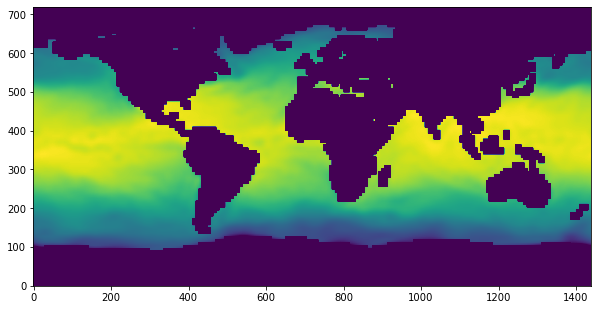

In [17]:
# plot the data
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(data, origin="lower", vmin=-11, vmax=30)

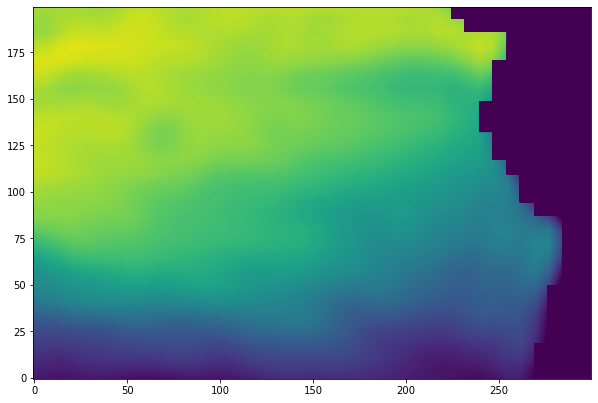

In [18]:
# plot a sub-region
plt.figure(1, figsize=(10,10),dpi=72)
plt.imshow(data[200:400, 150:450], origin="lower", vmin=11, vmax=30)  

In [19]:
# get just the non-fill values
non_fill = data[data != fill_value]

In [20]:
# create a histogram
histo = np.histogram(non_fill, bins=1000)

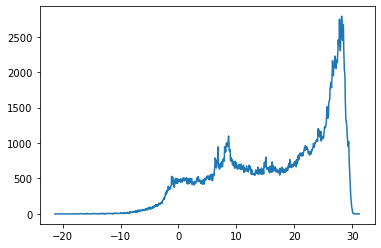

In [21]:
# plot it
plt.plot(histo[1][:-1], histo[0])

In [22]:
# get a time series by accessing each time for a given lat/lon value
# takes a while since 7855 chunks will be read.
start_index = 0
end_index = 7855   # set end_index to value between 1 an 7855
%time tseries = tair2m[start_index:end_index, 350, 600]

CPU times: user 10.7 ms, sys: 1.82 ms, total: 12.5 ms
Wall time: 2min 1s


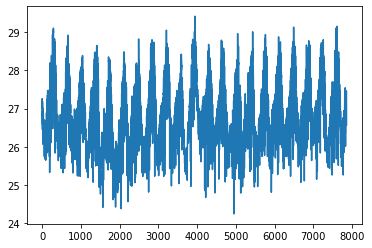

In [23]:
x = range(start_index,end_index)
plt.plot(x, tseries)

In [24]:
# calculate mean, median, stddev, min, max
end_index = 100
summaries = np.zeros((end_index-start_index, 5))
def calc_summaries():
    for i in range(start_index, end_index):
        data = tair2m[i, :,:]
        non_fill = data[data != fill_value]
        summary = (np.mean(non_fill), np.median(non_fill), np.std(non_fill), np.min(non_fill), np.max(non_fill))
        summaries[i] = summary
%time calc_summaries()

CPU times: user 2.51 s, sys: 465 ms, total: 2.97 s
Wall time: 20.7 s


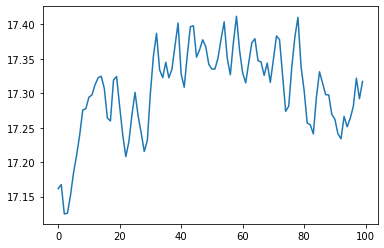

In [25]:
x = range(start_index,end_index)
plt.plot(x, summaries[:,0])